# Roughness parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from platypus.core import Problem
from platypus.types import Real,random
from platypus.algorithms import NSGAIII
import warnings
warnings.filterwarnings('ignore')

This is a custom package specifically designed for this analysis. It contains various functions for reading and computing and plotting.

In [2]:
from z0_util import cal_vap_sat, cal_dens_dry, cal_dens_vap, cal_cpa, cal_dens_air, cal_Lob

## Function to calculate Neutral condition

In [13]:
def cal_neutral(df_val,z_meas,h_sfc):

    # calculate Obukhov length
    ser_Lob = df_val.apply(
        lambda ser: cal_Lob(ser.H, ser.USTAR, ser.TA, ser.RH, ser.PA * 10), axis=1)

    # zero-plane displacement: estimated using rule f thumb `d=0.7*h_sfc`

    z_d = 0.7 * h_sfc

    if z_d >= z_meas:
        print(
            'vegetation height is greater than measuring height. Please fix this before continuing'
        )

    # calculate stability scale
    ser_zL = (z_meas - z_d) / ser_Lob

    # determine periods under quasi-neutral conditions
    limit_neutral = 0.01
    ind_neutral = ser_zL.between(-limit_neutral, limit_neutral)
    
    
    ind_neutral=ind_neutral[ind_neutral]
    df_sel = df_val.loc[ind_neutral.index, ['WS', 'USTAR']].dropna()
    ser_ustar = df_sel.USTAR
    ser_ws = df_sel.WS
    
    
    return ser_ws,ser_ustar

## Function to calculate z0 and d using MO optimization

In [14]:
def optimize_MO(df_val,z_meas,h_sfc):
    
    
    ser_ws,ser_ustar=cal_neutral(df_val,z_meas,h_sfc)

    def func_uz(params):
        z0=params[0]
        d=params[1]
        z = z_meas
        k = 0.4
        uz = (ser_ustar / k) * np.log((z - d) / z0)

        o1=abs(1-np.std(uz)/np.std(ser_ws))
        o2=np.mean(abs(uz-ser_ws))/(np.mean(ser_ws))

        return [o1,o2],[uz.min(),d-z0]

    problem = Problem(2,2,2)
    problem.types[0] = Real(0, 10)
    problem.types[1] = Real(0, h_sfc)


    problem.constraints[0] = ">=0"
    problem.constraints[1] = ">=0"

    problem.function = func_uz
    random.seed(12345)
    algorithm=NSGAIII(problem, divisions_outer=50)
    algorithm.run(30000)

    z0s=[]
    ds=[]
    os1=[]
    os2=[]
    for s in algorithm.result:
        z0s.append(s.variables[0])
        ds.append(s.variables[1])
        os1.append(s.objectives[0])
        os2.append(s.objectives[1])
        
    idx=os2.index(min(os2, key=lambda x:abs(x-np.mean(os2))))
    z0=z0s[idx]
    d=ds[idx]

    return z0,d,ser_ws,ser_ustar

## Loading data, cleaning and getting ready for optimization

In [15]:
name_of_site='US-MMS'
years=[2010,2012,2016]


df_attr=pd.read_csv('all_attrs.csv')
z_meas=df_attr[df_attr.site==name_of_site].meas.values[0]
h_sfc=df_zmeas=df_attr[df_attr.site==name_of_site].height.values[0]
folder='data/data_csv_zip_clean_roughness/'
site_file = folder+'/'+name_of_site + '_clean.csv.gz'
df_data = pd.read_csv(site_file, index_col='time', parse_dates=['time'])
# Rain
bb=pd.DataFrame(~np.isin(df_data.index.date,df_data[df_data.P!=0].index.date))
bb.index=df_data.index
df_data=df_data[bb.values]


df_data=df_data[(df_data['WS']!=0)]

df_years=df_data.loc[f'{years[0]}']
for i in years[1:]:
    df_years=df_years.append(df_data.loc[f'{i}'])

df_val = df_years.loc[:, ['H', 'USTAR', 'TA', 'RH', 'PA', 'WS']].dropna()
df_val.head()

,H,USTAR,TA,RH,PA,WS
time,,,,,,
2010-01-01 00:00:00,21.873,0.739,-8.08,70.503,98.836,3.695
2010-01-01 01:00:00,41.819,0.855,-9.17,72.757,98.880,3.928
2010-01-01 02:00:00,-6.078,0.699,-9.63,72.611,98.910,3.088
2010-01-01 03:00:00,-16.788,0.581,-10.03,73.868,98.970,3.623
2010-01-01 04:00:00,5.006,0.562,-10.36,74.242,99.030,3.474


## Calculating z0 and d

In [16]:
z0,d,ser_ws,ser_ustar=optimize_MO(df_val,z_meas,h_sfc)

## Calculating model wind speed using logarithmic law

In [17]:
def uz(z0,d,ser_ustar,z_meas):
    z = z_meas
    k = 0.4
    uz = (ser_ustar / k) * np.log((z - d) / z0)
    return uz

ws_model=uz(z0,d,ser_ustar,z_meas)

(0.0, 10.0)

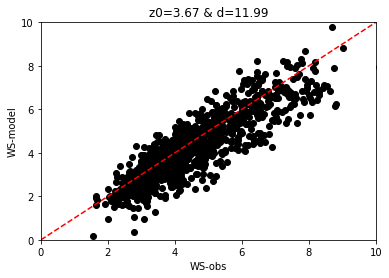

In [18]:
plt.scatter(ser_ws,ws_model,color='k')
plt.xlabel('WS-obs')
plt.ylabel('WS-model')
plt.title(f'z0={np.round(z0,2)} & d={np.round(d,2)}')
plt.plot([0,10],[0,10],color='r',linestyle='--')
plt.ylim([0,10])
plt.xlim([0,10])